<div style="text-align:center">
    <h1><b>KLASIFIKASI IKAN SEHAT DENGAN IKAN TERINFEKSI PENYAKIT BERDASARKAN CITRA KULITNYA</b></h1>
    <h1><b></b></h1>
</div>
<br><br>
<br><br>
<table style="width:100%;">
    <tr>
        <td align="center">
            <img src="UNRAM-LOGO.png" alt="Foto" width="500" height="500">
        </td>
    </tr>
</table>
<br><br>
<br><br>
<div style="text-align:center">
    <h2>Disusun Oleh:</h2>
    <h2>MUHAMMAD ADHITYA NUGRAHA: F1D02310016</h2>
    <h2>MUHAMMAD RIDHO AIDIL FURQON: F1D02310127</h2>
    <h2>IRFAN JAYADI: F1D02310011<h2>
    <h2>MUHAMMAD FARUK WIRA PRABUANA JAMALUDIN: F1D02310147</h2>
</div>
<br><br><br><br>
<br><br><br><br>
<div style="text-align:center">
    <h2>UNIVERSITAS MATARAM</h2>
    <h2>FAKULTAS TEKNIK</h2>
    <h2>TEKNIK INFORMATIKA</h2>
    <h2>2024/2025</h2>
</div>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>


## Latar Belakang


In [2]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

DATA LOADING

In [18]:
data = []
labels = []
file_name = []
target_size = (256, 256)
for sub_folder in os.listdir("Dataset"):
    sub_folder_files = os.listdir(os.path.join("Dataset", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Dataset", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, target_size)

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)



Data Understanding

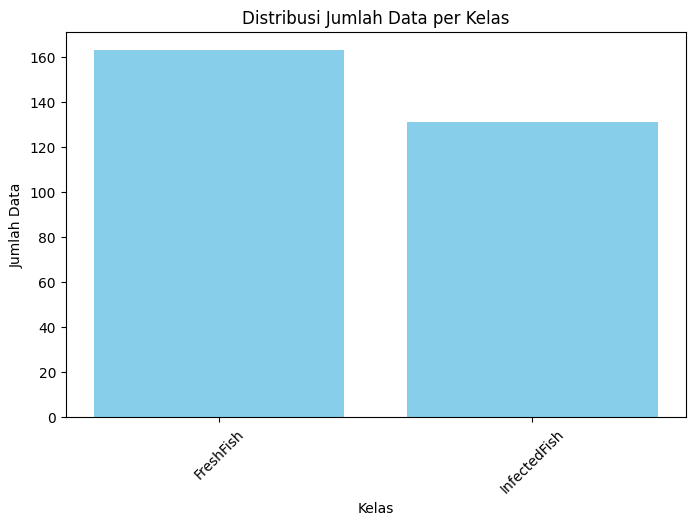

In [19]:
# Menampilkan jumlah data per kelas
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Jumlah Data per Kelas")
plt.xticks(rotation=45)
plt.show()

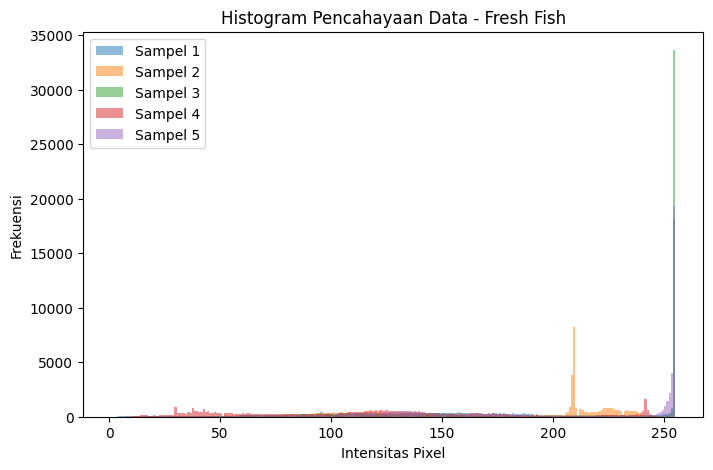

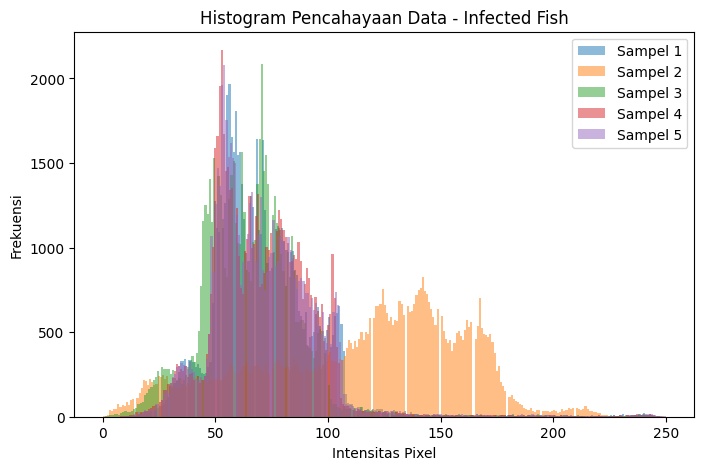

In [20]:
fresh_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "FreshFish"]
infected_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "InfectedFish"]

plt.figure(figsize=(8, 5))
for i in range(min(5, len(fresh_fish_samples))):
    img = fresh_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Fresh Fish")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(min(5, len(infected_fish_samples))):  
    img = infected_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Infected Fish")
plt.legend()
plt.show()

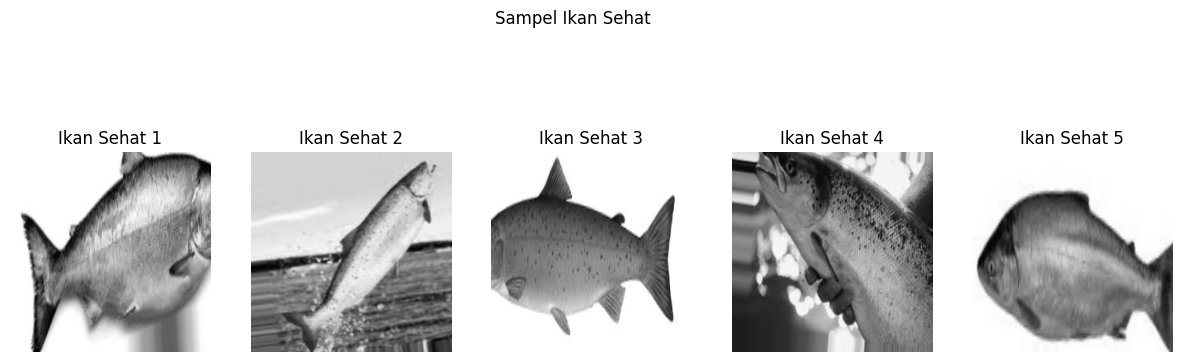

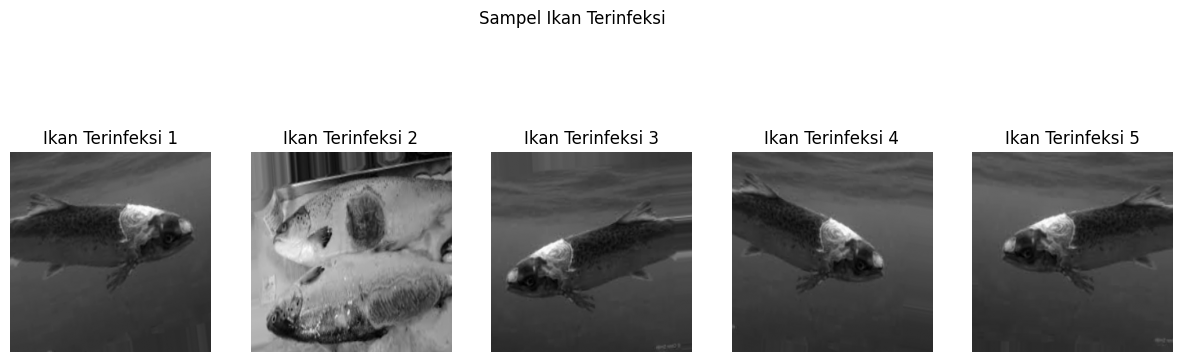

In [21]:
# Menampilkan sampel ikan sehat
fig, axes = plt.subplots(1, min(5, len(fresh_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(fresh_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(fresh_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Sehat {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Sehat")
plt.show()

fig, axes = plt.subplots(1, min(5, len(infected_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(infected_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(infected_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Terinfeksi {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Terinfeksi")
plt.show()

DEFINE DATA AUGMENTATION

In [4]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	img = data[i]
	label = labels[i]
	filename = file_name[i]

    # Augmentasi Flip Horizontal & Vertikal
	img_flip_h = cv.flip(img, 1)  # Flip horizontal
	img_flip_v = cv.flip(img, 0)  # Flip vertikal

    # Augmentasi Rotasi 90° & 180°
	img_rot_90 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
	img_rot_180 = cv.rotate(img, cv.ROTATE_180)

    # Augmentasi Translasi (Shift)
	rows, cols = img.shape[:2]
	M_trans = np.float32([[1, 0, 20], [0, 1, 20]])  # Geser 20 pixel kanan & bawah
	img_translated = cv.warpAffine(img, M_trans, (cols, rows))

	for augmented_img, suffix in [(img_flip_h, "flip_h"), (img_flip_v, "flip_v"), (img_rot_90, "rot_90"), (img_rot_180, "rot_180"), (img_translated, "translated")]:
		data_augmented.append(augmented_img)
		labels_augmented.append(label)
		file_name_augmented.append(f"{filename}_{suffix}")

print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  305
Data setelah augmentasi:  1525


PREPROSSESING

In [ ]:
def resize(image, target_size):
    pass

def prepro1():
    pass

def prepro2():
    pass

def prepro3():
    pass

In [ ]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)): # Loop through each image and do preprocessing
	pass

FEATURE EXTRACTION

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [ ]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [ ]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [ ]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [ ]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [ ]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [ ]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [ ]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [ ]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [ ]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [ ]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [ ]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [ ]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [ ]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [ ]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [ ]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [ ]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Write the extraction's results to CSV

In [ ]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

In [ ]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

Splitting Data

In [ ]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

Feature Normalization

In [ ]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Modeling
Define Model

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Train Random Forest Classifier

In [ ]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

Train SVM Classifier

In [ ]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)

Train KNN Classifier

In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)

Evaluation With Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")